# Расчетная работа по курсу: Теория вероятности и статистика<br/>Раздел 1

## Импортируем все необходимые библиотеки

Здесь:
- Numpy и его подмодули:
    - `numpy` - общий модуль для работы с тензорами и статистических вычислений

- SciPy и его подмодули
    - `stats` - для получения функции плотности вероятности из модуля `norm`
    - `optimize` - для получения функции минимизации
    - `integrate` - для подсчета интеграла

- MatPlotLib и Seaborn:
    - `matplotlib.pyplot` или `plt` - для графиков

In [1]:
import numpy as np

from scipy import stats
from scipy import optimize
import scipy.integrate as integrate

import matplotlib.pyplot as plt

import re

## Вводим константы по варианту и `SEED` для повторяемости результатов
$n=500$
<br/>$a_X=3.9$
<br/>$\sigma_X^2=4.3$
<br/>$\gamma=0.9$
<br/>$\alpha=0.025$<br/><br/>
Где:
<br/>$n$ - объем выборки
<br/>$a_X$ - математическое ожидание (mean)
<br/>$\sigma_X^2$ - дисперсия
<br/>$\gamma$ - доверительная вероятность
<br/>$\alpha$ - уровень значимости

In [2]:
n = 500             # Размер выборки
MX = 3.9            # Мат. ожидание 
DX = 4.3            # Дисперсия
SIGMA = np.sqrt(DX) # Среднее квадратичное отклонение, квадратный корень дисперсии

SEED = 228          # Для повторяемости результатов

## 1.0 Функция нормального (Гауссовского) распределения случайной величины
$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-a)^{2}}{2\sigma^{2}}}$$

Для генерации выборки воспльзуемся `scipy`

In [3]:
x: np.ndarray = stats.norm.rvs(loc=MX, scale=SIGMA, size=n, random_state=SEED)
print(f"Первые 6 значений вектора:\n{re.sub(" +", ", ", str(x[:6])[2:-1])}...")
print(f"Размерность выборки: {str(x.shape)[1:-2]}")

Первые 6 значений вектора:
6.53625429, -0.91170967, 1.67480578, 6.62595839, 8.13722897, 0.99881286...
Размерность выборки: 500


## 1.1 Гистограмма полученного вектора выборки и теоретической
Получанный вектор:

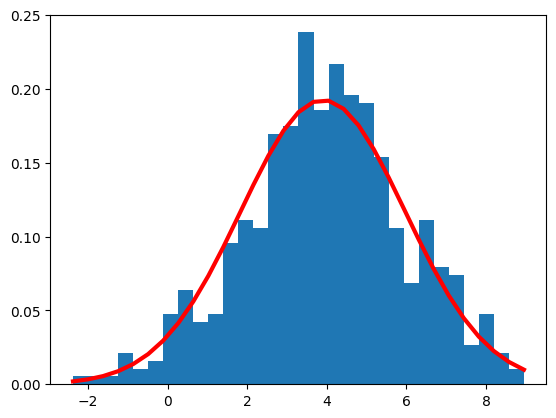

In [4]:
_, theoretic_x, _ = plt.hist(x, 30, density=True)

theoretic_normal_distribution = 1 / \
    (SIGMA * np.sqrt(2 * np.pi)) * \
    np.exp(- (theoretic_x - MX)**2 / (2 * SIGMA**2))

plt.plot(theoretic_x, theoretic_normal_distribution, linewidth=3, color='r')
plt.show()

## 1.2 Выборчная средняя и дисперсия

Формула для выборочной средней:

$$\bar{X} = \frac{1}{n}\sum_{i=0}^{n-1}x_{i}$$

Формула для выборочной дисперсии:

$$S^2 = \frac{1}{n}\sum_{i=0}^{n-1}(x_{i}-\bar{x})^2$$

In [5]:
sample_average = x.sum() / n

sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - sample_average) ** 2

sample_variance = sum_tmp / n

print(f"Выборочная средняя: {sample_average}\nВыборочная дисперсия: {sample_variance}")

Выборочная средняя: 3.9615039118502553
Выборочная дисперсия: 4.096479344316209


## 1.3 Получить оценки мат. ожидания и дисперсии методом максимального правдоподобия

In [6]:
def likelihood(params, x):
    return stats.norm.logpdf(x, loc=params[0], scale=params[1]).sum()

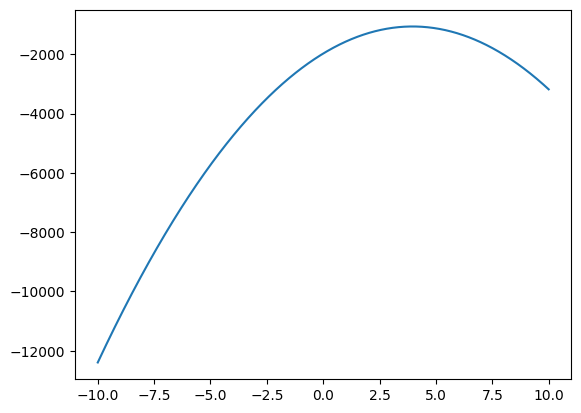

In [7]:
plt.plot(np.linspace(-10, 10, 1000), [likelihood([val, SIGMA], x) for val in np.linspace(-10, 10, 1000)])
plt.show()

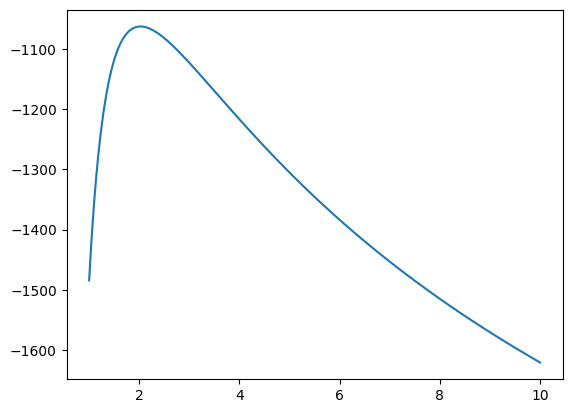

In [8]:
plt.plot(np.linspace(1, 10, 1000), [likelihood([MX, val], x) for val in np.linspace(1, 10, 1000)])
plt.show()

In [9]:
def neglikelihood_MX(MX):
    return -1 * likelihood([MX, SIGMA], x)

def neglikelihood_SIGMA(SIGMA):
    return -1 * likelihood([MX, SIGMA], x)

In [10]:
estimator_MX = optimize.minimize(neglikelihood_MX, 10)
estimator_SIGMA = optimize.minimize(neglikelihood_SIGMA, 10)
print(f"Оценка мат. ожидания: {str(estimator_MX.x)[1:-1]}\nОценка дисперсии: {str(estimator_SIGMA.x ** 2)[1:-1]}")

Оценка мат. ожидания: 3.96150394
Оценка дисперсии: 4.10026194


### Несмещнная оценка дисперсии
$$S'^{2}=\frac{1}{n-1}\sum^{n}_{i=1}(X_i-\bar{X})^2=\frac{n}{n-1}S^2$$

Тогда несмещенную оценку посчитаем используя выборочную дисперсию $S^2$

In [11]:
unbiased_variance = (n * sample_variance) / (n - 1)
print(f"Несмещенная оценка дисперсии: {unbiased_variance}")

Несмещенная оценка дисперсии: 4.104688721759729


## 1.4 Построить доверительные интервалы для MX и DX, соответсвующие $\gamma$

### Формулы:

Формула для нахождения интервальной оценки MX, при известном DX: 
$$\Delta_{\gamma}(\theta)=(\bar{X}-c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}},\bar{X}+c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}})$$

где $\bar{X}$ - выборочное среднее<br/>*n* - размер выборки<br/>$c_{(1+\gamma)/2}$ - такое значение функции Лапласа $Ф(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-u^2/2}du$, при котором $Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$<br/>$c_{(1+\gamma)/2}$ находят по таблице Б.2

Формула для нахождения интервальной оценки DX, при известном MX:
$$\Delta_{\gamma}(\theta^2)=\Big(\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1+\gamma)/2;n}};\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1-\gamma)/2;n}}\Big)$$

где $\chi^2_{(1+\gamma)/2;n}$ это $(1+\gamma)/2$ квантили распределения $\chi^2(n)$ с *n* степенями свободы<br/>
Искать в таблице Г.2

### Найдем интервальную оценку MX
Получим $c_{(1+\gamma)/2}$ используя таблицу, при $\gamma=0.9$.<br/><br/>
Решим уравнение:
$$Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$$
$$Ф(c_{(1+\gamma)/2})=0.95$$
Тогда $c_{(1+\gamma)/2}=1.645$

In [12]:
interval_MX = sample_average - 1.645 * (SIGMA / np.sqrt(n)), sample_average + 1.645 * (SIGMA / np.sqrt(n))

print(f"Интервальная оценка MX: {interval_MX}")

Интервальная оценка MX: (3.808952887599351, 4.11405493610116)


### Найдем интервальную оценку DX
Так как $n\ge30$ ($n=500$), то воспользуемся формулой: $$\chi^2_{\gamma,n}\approx\frac{(c_p+\sqrt{2n-1})^2}{2}$$
где $c_p$ квантиль нормального распределения из таблицы Б.2 <br/>
Возьмем значения из таблицы: 
$$c_p=1.645 \quad \text{(при} \> p=(1+\gamma)/2=0.95\text{)}$$
$$c_p=-1.645 \quad \text{(при} \> p=(1-\gamma)/2=0.05\text{)}$$
<br/>Тогда:
$$\chi^2_{(1+\gamma)/2;n}\approx552.84646$$
$$\chi^2_{(1-\gamma)/2;n}\approx448.85956$$

In [13]:
sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - MX) ** 2

interval_DX = sum_tmp / 552.84646, sum_tmp / 448.85956

print(f"Интервальная оценка DX: {interval_DX}")

Интервальная оценка DX: (3.708319010932163, 4.567422018915109)


## 1.5 Проверка статестической гипотизы

### 1. Группировка по интервальным статистическим рядам и вычисление значение статистики

#### 1.1 Группировка
##### 1.1.1 Построим вариационный ряд (упорядоченную выборку), то есть $x_1\le x_2\le ...\le x_n$

In [14]:
variation_series = x.copy()
variation_series.sort()
print(f"Вариационный ряд: {re.sub(" +", ", ", str(variation_series[:6])[1:-1])}...")

Вариационный ряд: -2.38007594, -1.92029146, -1.3173752, -1.17387686, -1.15810364, -0.91170967...


##### 1.1.2 Разбиваем на непересекающиеся интервалы
<br/>Найдем мин. и макс. значение в ряде

In [15]:
print(f"Минимальное: {min(variation_series)}")
print(f"Максимальное: {max(variation_series)}")

Минимальное: -2.3800759426760023
Максимальное: 8.953101770297726


Кол-во интервалов, *N*: 8

In [16]:
N = 8

Считаем длины интервалов: $$h=\frac{x_{max}-x_{min}}{N}$$

In [17]:
h = (max(variation_series) - min(variation_series)) / N
print(f"Длина интервала: {h}")

Длина интервала: 1.4166472141217161


Получаем такие интервалы:

In [18]:
J = [[min(variation_series) + k * h, min(variation_series) + (k + 1) * h] for k in range(N)]

for (n, interval) in enumerate(J):
    print(f"Интервал {n + 1}: {str(interval)[:-1]})")

Интервал 1: [-2.3800759426760023, -0.9634287285542862)
Интервал 2: [-0.9634287285542862, 0.45321848556742994)
Интервал 3: [0.45321848556742994, 1.869865699689146)
Интервал 4: [1.869865699689146, 3.286512913810862)
Интервал 5: [3.286512913810862, 4.703160127932579)
Интервал 6: [4.703160127932579, 6.119807342054294)
Интервал 7: [6.119807342054294, 7.536454556176009)
Интервал 8: [7.536454556176009, 8.953101770297726)


Разбиваем на интервалы

In [19]:
stat_series = [[] for _ in range(len(J))]

for xi in variation_series:
    for i in range(len(J)):
        if (J[i][0] <= xi < J[i][1]):
            stat_series[i].append(xi)
stat_series[-1].append(max(variation_series))

##### 1.1.3 Теперь подсчитаем частоты

In [20]:
frequencies = []

for interval in stat_series:
    frequencies.append(len(interval))

print(f"Частоты попадания выборочных значений: {frequencies}")
print(f"Сумма частот: {sum(frequencies)}")

Частоты попадания выборочных значений: [5, 26, 45, 98, 150, 101, 57, 18]
Сумма частот: 500


#### 2. Считаем критерий Пирсона

Считаем по формуле: $$\chi^2_n=\sum^N_{k=1}\frac{(\nu_k-n p_k)^2}{n p_k}$$
Где $p_k$ считается по формуле: $$p_k = F(u_k)-F(u_{k-1})$$
Где $F(x)$ это: $$F(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-t^2/2}dt$$
Напишем функцию $F(x)$

In [21]:
def F(x):
    return (1 / (2 * np.pi)) * integrate.quad(lambda t: np.exp(-t**2 / 2), -np.inf, x)[0]

Тогда $p_k$ это:

In [22]:
p = [F(val[-1]) - F(val[0]) for val in J]

for (k, pk) in enumerate(p):
    print(f"p{k + 1} = {pk}")

p1 = 0.06343647914213058
p2 = 0.20231882258591982
p3 = 0.11746635083516155
p4 = 0.012065632031764362
p5 = 0.00020182481464364743
p6 = 5.107890727606978e-07
p7 = 1.8687207337109157e-10
p8 = 2.088884620832232e-13


In [23]:
chi = 0
for k in range(N):
    chi += (frequencies[k] - n * p[k])**2 / n * p[k]
print(f"Критерий Пирсона: {chi}")

Критерий Пирсона: 67.5815939297418


### 3. Проверяем гипотезу
По заданной $\alpha=0.025$ найдем порог для $\chi^2_{1-\alpha;N-1}$ по таблице Г.1 
$$1-\alpha=1-0.025=p=0.975$$
$$N-1=7$$
Где $N$ - это кол-во интервалов (то есть $N=8$)

Тогда по таблице $\chi^2_{1-\alpha;N-1}=16.013$<br/>
Так как критерий Пирсона $\chi > 16.013 \Rightarrow$ Гипотеза отвергается